In [1]:
import os
print(os.getcwd())

# data_dir = os.getcwd()+"/paper/"
# print(data_dir)

os.chdir("/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo/examples/paper")


/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo/examples


In [2]:
from initialize import *
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


data_name = 'givemecredit'
data_file = data_dir / ('%s/cs-training.csv' % (data_name))

output_dir = results_dir / data_name
raw_df = pd.concat([pd.read_csv(data_file, index_col=0), ])

In [3]:
raw_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,...,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,...,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,...,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,...,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,...,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,...,7,0,1,0,0.0


# Load and Prepare Data

### Split and train classifiers

In [ ]:
# # 1. Out of Sample Costs
## sample the dataset
## preprocess and prepare

# original dataset. put aside 10,000 as holdout.
# remaining 40,000. split into age groups.
# over 35 should be included in both
# for the other add in the other.
# don't include age as a feature

y = 1 - raw_df['SeriousDlqin2yrs'].reset_index(drop=True)
X = raw_df.drop('SeriousDlqin2yrs', axis=1).fillna(0).reset_index(drop=True)

## split datasets for audit
X_clf, X_audit_holdout, y_clf, y_audit_holdout = train_test_split(X, y, test_size=.25)

X_clf_biased = X_clf.loc[lambda df: df['age'] >= 35] # .drop('age', axis=1)

y_clf_biased = y_clf.loc[X_clf_biased.index]



## train
clf_full = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X_clf, # .drop('age', axis=1),
             y_clf)
)
clf_age_limited = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X_clf_biased, y_clf_biased)
)

In [112]:
print(X.shape)
print(X_clf.shape)
print(X_clf_biased.shape)
print(X_audit_holdout.shape)

(150000, 10)
(112500, 10)
(98030, 10)
(37500, 10)


### Run Predictions and store in a unified dataframe

In [5]:
coefficients = {}
intercept = {}
clfs = {'full': clf_full, 'downsampled': clf_age_limited}
for d in ['downsampled', 'full']:
    coefficients[d] = clfs[d].coef_[0]
    intercept[d] = clfs[d].intercept_[0]

# Run Audit

In [6]:
# actionset
action_set = ActionSet(X=X_audit_holdout)
action_set['age'].mutable = False
action_set['NumberOfDependents'].mutable = False
action_set['DebtRatio'].step_direction = -1

In [7]:
# utilization bounded
# RealEstate should be positive
# numtimes90 days > 0
# monthly income >0
# debt

p = 0.98

# run audit
audit_results = {}
for dataset in ['full', 'downsampled']:
    action_set.align(coefficients=coefficients[dataset])
    
    # audit
    auditor = RecourseAuditor(
        action_set,
        coefficients = coefficients[dataset],
        intercept = intercept[dataset] - (np.log(p / (1. - p))),
    )
    audit_results[dataset] = auditor.audit(X = X_audit_holdout)

### Visualize

In [32]:
# audit_results['full'].isnull().values.any()

In [28]:
# combined = pd.concat([audit_results['full'], audit_results['downsampled']])

print(processed_data['full']['cost'].max())
print(processed_data['downsampled']['cost'].max())

print(max(processed_data['full']['cost'].max(), processed_data['downsampled']['cost'].max()))

0.6071355890723072
0.9868099942268544
0.9868099942268544


In [34]:
processed_data['full'].tail()

,feasible,cost,age,y_true,age_cut
39487,True,0.167675,65,1,"(60, 65]"
23989,True,0.132792,60,1,"(55, 60]"
121524,True,0.167675,50,1,"(45, 50]"
125757,True,0.167675,46,1,"(45, 50]"
83341,True,0.179991,45,1,"(40, 45]"


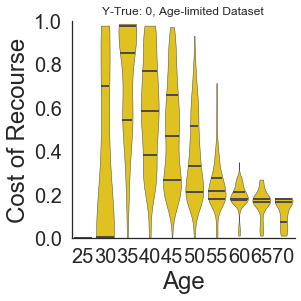

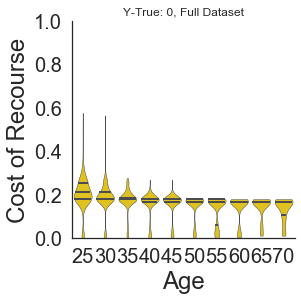

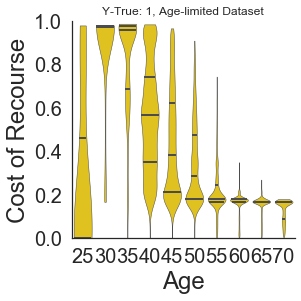

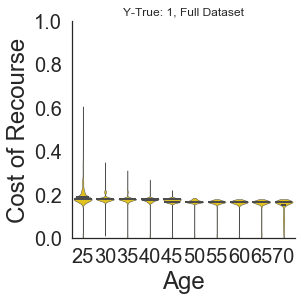

In [56]:
## mild processing

processed_data = {}
for training_run in ['full', 'downsampled']:
    processed_data[training_run] = (audit_results[training_run]
                .merge(X_audit_holdout['age'], right_index=True, left_index=True)
                .merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
                .replace([np.inf, -np.inf], np.nan)
                .assign(age_cut=lambda df: pd.cut(df['age'], np.arange(25, 80, 5)))
                .dropna()
               )

xlab = processed_data['full'].age_cut.unique()
    
## plot
# max_total_cost = combined['cost'].max()
max_total_cost = max(processed_data['full']['cost'].max(), processed_data['downsampled']['cost'].max())

plt.rc("font", size=20)
for y_true in [0, 1]:
    for training_run, label in [('downsampled', 'Age-limited Dataset'), ('full', 'Full Dataset')]:
        data = processed_data[training_run]       
        plt.figure(figsize=(4, 4))
        ax = sns.violinplot(
                x='age_cut', y='cost',
                data=data.loc[lambda df: df['y_true'] == y_true],
                linewidth = 0.5, cut=0,
                scale='width', color="gold",  inner='quartile'
                )
        
        ## formatting
        plt.ylim((0, max_total_cost))
        plt.ylabel("Cost of Recourse")
        plt.xlabel("Age")
        plt.title('Y-True: %s, %s' % (y_true, label))
        ax.set_ylim((0, 1))
#         plt.xticks(rotation=90)
#         ax.set_xticks(np.arange(0, 14, 2)- 1,)
        ax.set_xticklabels(xlab)
        ax.set_xticklabels(np.arange(25, 80, 5))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for l in ax.lines:
            l.set_linewidth(2.)
            l.set_linestyle('-')
            l.set_solid_capstyle('butt')
        ax.set_facecolor("white")
        plt.show()

## accuracy

In [108]:
print("\n TESTING ACCURACIES: \n")
print("total number of data points in testing set: ")
print(X_audit_holdout.shape)
predictions_baseline_test = pd.DataFrame({'y_pred': clf_full.predict(X_audit_holdout)})
predictions_baseline_test = predictions_baseline_test.merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
# print(predictions_baseline_test.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("testing accuracy for baseline: ")
print(predictions_baseline_test.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_audit_holdout.shape[0])

predictions_biased_test = pd.DataFrame({'y_pred': clf_age_limited.predict(X_audit_holdout)})
predictions_biased_test = predictions_biased_test.merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
print("testing accuracy for biased: ")
print(predictions_biased_test.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_audit_holdout.shape[0])


print("\n TRAINING ACCURACIES: \n")
print("BASELINE")
print("total number of data points in training set: ")
print(X_clf.shape)
predictions_baseline = pd.DataFrame({'y_pred': clf_full.predict(X_clf)})
predictions_baseline = predictions_baseline.merge(y_clf.to_frame('y_true'), right_index=True, left_index=True)
print("total number of correct predictions in training set: ")
print(predictions_baseline.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("training accuracy for baseline: ")
print(predictions_baseline.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_clf.shape[0])

print("\nBIASED")
predictions_biased = pd.DataFrame({'y_pred': clf_age_limited.predict(X_clf)})
predictions_biased = predictions_biased.merge(y_clf.to_frame('y_true'), right_index=True, left_index=True)
print("total number of correct predictions in training set: ")
print(predictions_biased.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("training accuracy for biased: ")
print(predictions_biased.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_clf.shape[0])



 TESTING ACCURACIES: 

total number of data points in testing set: 
(37500, 10)
testing accuracy for baseline: 
0.2324
testing accuracy for biased: 
0.23258666666666666

 TRAINING ACCURACIES: 

BASELINE
total number of data points in training set: 
(112500, 10)
total number of correct predictions in training set: 
(78404, 2)
training accuracy for baseline: 
0.6969244444444445

BIASED
total number of correct predictions in training set: 
(78401, 2)
training accuracy for biased: 
0.6968977777777777


# Generate Flipsets

Let's identify one individual and look at the changes they'd have to make to make it past our threshold. First, 
we'll start with someone scored under the full model:

In [ ]:
from IPython.display import HTML

In [ ]:
## get flipset

## min-cost:
dataset = 'full'
scores = clfs[dataset].predict_proba(X_audit_holdout)[:, 1] # .drop('age', axis=1))[:, 1]
score_df = pd.Series(scores, index=X_audit_holdout.index).to_frame('y_full_score')

action_set.align(coefficients[dataset])  ## remember, if we're using the same actionset, we have to re-align
                                         ## it to use the right coefficients.
young_individuals = (processed_data[dataset]
    .merge(score_df, right_index=True, left_index=True)
    .loc[lambda df: df['age'] < 30]
    .loc[lambda df: df['y_full_score'] > .90]
    .loc[lambda df: df['y_full_score'] < .98 ]
    .index
    )

k = 4
fb = Flipset(
    x = X_audit_holdout.loc[young_individuals[k]].values, 
    action_set = action_set, 
    coefficients = coefficients[dataset],
    intercept = intercept[dataset] - (np.log(p / (1. - p))),
)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 14)

In [116]:
HTML(fb.to_html())

Now, we'll look at the changes they'd have to make if the model were trained without including young people:

In [ ]:
dataset = 'downsampled'
k = 4
action_set.align(coefficients[dataset]) ## remember, if we're using the same actionset, we have to re-align
                                        ## it to use the right coefficients.
fb = Flipset(
    x = X_audit_holdout.loc[young_individuals[k]].values, 
    action_set = action_set, 
    coefficients = coefficients[dataset],
    intercept = intercept[dataset] - (np.log(p / (1. - p))),
)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 14)

In [118]:
HTML(fb.to_html())

Not only do they have less options, but many of them are pretty ridiculous. 